# Vanilla LSTM with CuPy

This is a port of [Vanilla LSTM with numpy](http://blog.varunajayasiri.com/numpy_lstm.html) that shows how to run the numpy-based machine learning code on GPU using CuPy. The all contents below is basically copied from the article: [Vanilla LSTM with numpy](http://blog.varunajayasiri.com/numpy_lstm.html).

This is inspired from [Minimal character-level language model with a Vanilla Recurrent Neural Network](https://gist.github.com/karpathy/d4dee566867f8291f086), in Python/numpy by [Andrej Karpathy](https://github.com/karpathy).

The model usually reaches an error of about 45 after 5000 iterations when tested with [100,000 character sample from Shakespeare](http://cs.stanford.edu/people/karpathy/char-rnn/shakespear.txt). However it sometimes get stuck in a local minima; reinitialize the weights if this happens.

You need to place the input text file as `input.txt` in the same folder as the python code.

## Download data

In [1]:
%%bash
curl -L http://cs.stanford.edu/people/karpathy/char-rnn/shakespear.txt -o input.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 99993  100 99993    0     0  69435      0  0:00:01  0:00:01 --:--:--  157k


## Imports

In [2]:
import numpy as np
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

The above imports are from the original article as is. But in this article, you can run almost all computation on GPU by just replacing `np` with `cp`. Well, `cp` is just another name of `cupy`.

In [3]:
import cupy as cp

To show the difference of computational time by switching CPU and GPU simply, let's use `xp` instead of `np` and switch the referenced package between `numpy` and `cupy`.

In [4]:
# If you use CPU
# xp = np

# If you use GPU
xp = cp

**Because CuPy has high compatibility with NumPy, the same code using NumPy is super easily converted for CuPy by just replacing `numpy` with `cupy`**.

## Read and process data

In [5]:
data = open('input.txt', 'r').read()

#### Process data and calculate indexes

In [6]:
chars = list(set(data))
data_size, X_size = len(data), len(chars)
print("data has %d characters, %d unique" % (data_size, X_size))
char_to_idx = {ch:i for i,ch in enumerate(chars)}
idx_to_char = {i:ch for i,ch in enumerate(chars)}

data has 99993 characters, 62 unique


## Parameters

In [7]:
H_size = 100 # Size of the hidden layer
T_steps = 25 # Number of time steps (length of the sequence) used for training
learning_rate = 1e-1 # Learning rate
weight_sd = 0.1 # Standard deviation of weights for initialization
z_size = H_size + X_size # Size of concatenate(H, X) vector

## Activation Functions and Derivatives

### Sigmoid

$$
\begin{eqnarray}
\sigma(x) &=& \frac{1}{1 + e^{-x}} \\
\frac{d \sigma(x)}{d x} &=& \sigma(x) \cdot (1 - \sigma(x))
\end{eqnarray}
$$

### Tanh

$$
\frac{d \tanh(x)}{dx} = 1 - \tanh^2(x)
$$

In [8]:
def sigmoid(x):
    return 1 / (1 + xp.exp(-x))


def dsigmoid(y):
    return y * (1 - y)


def tanh(x):
    return xp.tanh(x)


def dtanh(y):
    return 1 - y * y

## Initialize weights

We use random weights with normal distribution `(0, weight_sd)` for `tanh` activation function and `(0.5, weight_sd)` for `sigmoid` activation function.

Biases are initialized to zeros.

Formulae for LSTM are shown below.

In [9]:
W_f = xp.random.randn(H_size, z_size) * weight_sd + 0.5
b_f = xp.zeros((H_size, 1))

W_i = xp.random.randn(H_size, z_size) * weight_sd + 0.5
b_i = xp.zeros((H_size, 1))

W_C = xp.random.randn(H_size, z_size) * weight_sd
b_C = xp.zeros((H_size, 1))

W_o = xp.random.randn(H_size, z_size) * weight_sd + 0.5
b_o = xp.zeros((H_size, 1))

#For final layer to predict the next character
W_y = xp.random.randn(X_size, H_size) * weight_sd
b_y = xp.zeros((X_size, 1))

## Gradients

In [10]:
dW_f = xp.zeros_like(W_f)
dW_i = xp.zeros_like(W_i)
dW_C = xp.zeros_like(W_C)

dW_o = xp.zeros_like(W_o)
dW_y = xp.zeros_like(W_y)

db_f = xp.zeros_like(b_f)
db_i = xp.zeros_like(b_i)
db_C = xp.zeros_like(b_C)

db_o = xp.zeros_like(b_o)
db_y = xp.zeros_like(b_y)

### Forward pass

![](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png)

Image taken from [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/). Please read the article for a good explanation of LSTMs.

### Concatenation of $h_{t-1}$ and $x_t$

$$
z = [h_{t-1}, x_t]
$$

### LSTM functions

$$
\begin{eqnarray}
f_t &=& \sigma(W_f \cdot z + b_f) \\
i_t &=& \sigma(W_i \cdot z + b_i) \\
\bar{C}_t &=& \tanh(W_C \cdot z + b_C) \\
C_t &=& f_t \ast C_{t-1} + i_t \ast \bar{C}_t \\
o_t &=& \sigma(W_O \cdot z + b_t) \\
h_t &=& o_t \ast \tanh(C_t)
\end{eqnarray}
$$

### Logits

$$
y_t = W_y \cdot h_t + b_y
$$

### Softmax

$$
\hat{p}_t = {\rm softmax}(y_t)
$$

$\hat{p}_t$ is `p` in code and $p_t$ is `targets`.

In [11]:
def forward(x, h_prev, C_prev):
    assert x.shape == (X_size, 1)
    assert h_prev.shape == (H_size, 1)
    assert C_prev.shape == (H_size, 1)

    z = xp.concatenate((h_prev, x))
    f = sigmoid(xp.dot(W_f, z) + b_f)
    i = sigmoid(xp.dot(W_i, z) + b_i)
    C_bar = tanh(xp.dot(W_C, z) + b_C)

    C = f * C_prev + i * C_bar
    o = sigmoid(xp.dot(W_o, z) + b_o)
    h = o * tanh(C)

    y = xp.dot(W_y, h) + b_y
    p = xp.exp(y) / xp.sum(xp.exp(y))

    return z, f, i, C_bar, C, o, h, y, p

## Backward pass

### Loss

$$
\mathcal{L} = - \sum p_{t,j}log \hat{p}_{t,j}
$$

### Gradients

$$
\begin{eqnarray}
dy_t &=& \hat{p}_t - p_t \\
dh_t &=& dh'_{t+1} + W_y^T \cdot d_y \\
do_t &=& dh_t \ast \tanh (C_t) \\
dC_t &=& dC'_{t+q} + dh_t \ast o_t \ast (1 - \tanh^2(C_t)) \\
d \bar{C}_t &=& d C_t \ast i_t \\
d i_t &=& d C_t \ast \bar{C}_t \\
d f_t &=& d C_t \ast C_{t-1} \\
d z_t &=& W_f^T \cdot df_t + W_i^T \cdot di_t + W_C^T \cdot \bar{C}_t + W^T_o \cdot do_t \\
[dh'_t, dx_t] &=& dz_t \\
dC'_t &=& f \ast dC_t
\end{eqnarray}
$$

- `target` is target character index $p_t$
- `dh_next` is $dh_{t+1}$ (size $H \times 1$)
- `dC_next` is $dC_{t+1}$ (size $H \times 1$)
- `C_prev` is $C_{t-1}$ (size $H \times 1$)
- Returns $dh_t$ and $dC_t$

In [12]:
def backward(target, dh_next, dC_next, C_prev, z, f, i, C_bar, C, o, h, y, p):

    global dW_f, dW_i, dW_C, dW_o, dW_y
    global db_f, db_i, db_C, db_o, db_y

    assert z.shape == (X_size + H_size, 1)
    assert y.shape == (X_size, 1)
    assert p.shape == (X_size, 1)

    for param in [dh_next, dC_next, C_prev, f, i, C_bar, C, o, h]:
        assert param.shape == (H_size, 1)

    dy = xp.copy(p)
    dy[target] -= 1

    dW_y += xp.dot(dy, h.T)
    db_y += dy

    dh = xp.dot(W_y.T, dy)
    dh += dh_next
    do = dh * tanh(C)
    do = dsigmoid(o) * do
    dW_o += xp.dot(do, z.T)
    db_o += do

    dC = xp.copy(dC_next)
    dC += dh * o * dtanh(tanh(C))
    dC_bar = dC * i
    dC_bar = dC_bar * dtanh(C_bar)
    dW_C += xp.dot(dC_bar, z.T)
    db_C += dC_bar

    di = dC * C_bar
    di = dsigmoid(i) * di
    dW_i += xp.dot(di, z.T)
    db_i += di

    df = dC * C_prev
    df = dsigmoid(f) * df
    dW_f += xp.dot(df, z.T)
    db_f += df

    dz = xp.dot(W_f.T, df) \
        + xp.dot(W_i.T, di) \
        + xp.dot(W_C.T, dC_bar) \
        + xp.dot(W_o.T, do)
    dh_prev = dz[:H_size, :]
    dC_prev = f * dC

    return dh_prev, dC_prev

## Forward Backward Pass

Calculate and store the values in forward pass. Accumulate gradients in backward pass and clip gradients to avoid exploding gradients.

- `input`, `target` are list of integers, with character indexes.
- `h_prev` is the array of initial `h` at $h_1$ (size $H \times 1$)
- `C_prev` is the array of initial `C` at $C_1$ (size $H \times 1$)
- Returns loss, final $h_T$ and $C_T$

In [13]:
def forward_backward(inputs, targets, h_prev, C_prev):
    # To store the values for each time step
    x_s, z_s, f_s, i_s, C_bar_s, C_s, o_s, h_s, y_s, p_s = {}, {}, {}, {}, {}, {}, {}, {}, {}, {}

    # Values at t - 1
    h_s[-1] = xp.copy(h_prev)
    C_s[-1] = xp.copy(C_prev)

    loss = 0
    # Loop through time steps
    assert len(inputs) == T_steps
    for t in range(len(inputs)):
        x_s[t] = xp.zeros((X_size, 1))
        x_s[t][inputs[t]] = 1 # Input character

        z_s[t], f_s[t], i_s[t], C_bar_s[t], C_s[t], o_s[t], h_s[t], y_s[t], p_s[t] \
            = forward(x_s[t], h_s[t - 1], C_s[t - 1]) # Forward pass

        loss += -xp.log(p_s[t][targets[t], 0]) # Loss for at t


    for dparam in [dW_f, dW_i, dW_C, dW_o, dW_y, db_f, db_i, db_C, db_o, db_y]:
        dparam.fill(0)

    dh_next = xp.zeros_like(h_s[0]) #dh from the next character
    dC_next = xp.zeros_like(C_s[0]) #dh from the next character

    for t in reversed(range(len(inputs))):
        # Backward pass
        dh_next, dC_next = backward(target = targets[t], dh_next = dh_next, dC_next = dC_next, C_prev = C_s[t-1],
                 z = z_s[t], f = f_s[t], i = i_s[t], C_bar = C_bar_s[t], C = C_s[t], o = o_s[t],
                 h = h_s[t], y = y_s[t], p = p_s[t])

    # Clip gradients to mitigate exploding gradients
    for dparam in [dW_f, dW_i, dW_C, dW_o, dW_y, db_f, db_i, db_C, db_o, db_y]:
        xp.clip(dparam, -1, 1, out=dparam)

    return loss, h_s[len(inputs) - 1], C_s[len(inputs) - 1]

## Sample the next character

In [46]:
def sample(h_prev, C_prev, first_char_idx, sentence_length):
    x = xp.zeros((X_size, 1))
    x[first_char_idx] = 1

    h = h_prev
    C = C_prev

    indexes = []
    for t in range(sentence_length):
        _, _, _, _, C, _, h, _, p = forward(x, h, C)
        idx = xp.random.choice(xp.arange(X_size), size=(1,), p=p.ravel())
        x = xp.zeros((X_size, 1))
        x[idx] = 1
        indexes.append(idx)

    return indexes

## Training (Adagrad)

$$
w = w - \eta \frac{dw}{\sum dw^2_{\tau}}
$$

In [35]:
def update_status(inputs, h_prev, C_prev):
    #initialized later
    global plot_iter, plot_loss
    global smooth_loss

    # Get predictions for 200 letters with current model
    display.clear_output(wait=True)

    sample_idx = sample(h_prev, C_prev, inputs[0], 200)
    txt = ''.join(idx_to_char[idx] for idx in sample_idx)

    # Clear and plot
    plt.clf()
    plt.plot(plot_iter, plot_loss)
    display.display(plt.gcf())

    #Print prediction and loss
    print("----\n %s \n----" % (txt, ))
    print("iter %d, loss %f" % (iteration, smooth_loss))

Memory variables for Adagrad

In [36]:
mW_f = xp.zeros_like(W_f)
mW_i = xp.zeros_like(W_i)
mW_C = xp.zeros_like(W_C)
mW_o = xp.zeros_like(W_o)
mW_y = xp.zeros_like(W_y)

mb_f = xp.zeros_like(b_f)
mb_i = xp.zeros_like(b_i)
mb_C = xp.zeros_like(b_C)
mb_o = xp.zeros_like(b_o)
mb_y = xp.zeros_like(b_y)

In [37]:
# Exponential average of loss
# Initialize to a error of a random model
smooth_loss = -xp.log(1.0 / X_size) * T_steps

iteration, p = 0, 0

# For the graph
plot_iter = np.zeros((0))
plot_loss = np.zeros((0))

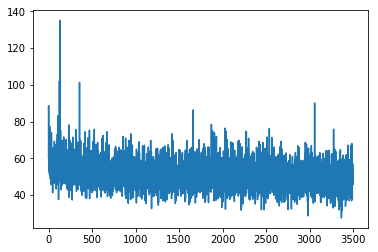

----
 entust, amaith of ouch le sept would
Whas 'dist itsbe wither, my maor; dapt ofer, stay thes you live juse hith than'ge pranged this moge spowire I dos. as of siin he grort fare foreco; the ut pame the 
----
iter 3500, loss 51.444035


In [ ]:
%%time
while True:
    # Try catch for interruption
    try:
        # Reset
        if p + T_steps >= len(data) or iteration == 0:
            g_h_prev = xp.zeros((H_size, 1))
            g_C_prev = xp.zeros((H_size, 1))
            p = 0


        inputs = [char_to_idx[ch] for ch in data[p: p + T_steps]]
        targets = [char_to_idx[ch] for ch in data[p + 1: p + T_steps + 1]]

        loss, g_h_prev, g_C_prev =  forward_backward(inputs, targets, g_h_prev, g_C_prev)
        smooth_loss = smooth_loss * 0.999 + loss * 0.001

        # Print every hundred steps
        if iteration % 100 == 0:
            update_status(inputs, g_h_prev, g_C_prev)


        # Update weights
        for param, dparam, mem in zip([W_f, W_i, W_C, W_o, W_y, b_f, b_i, b_C, b_o, b_y],
                                      [dW_f, dW_i, dW_C, dW_o, dW_y, db_f, db_i, db_C, db_o, db_y],
                                      [mW_f, mW_i, mW_C, mW_o, mW_y, mb_f, mb_i, mb_C, mb_o, mb_y]):
            mem += dparam * dparam # Calculate sum of gradients
            #print(learning_rate * dparam)
            param += -(learning_rate * dparam / xp.sqrt(mem + 1e-8))

        plot_iter = np.append(plot_iter, [iteration])
        if isinstance(loss, cp.ndarray):
            loss = loss.get()
        plot_loss = np.append(plot_loss, [loss])

        p += T_steps
        iteration += 1
        
        if iteration >= 5000:
            break
    except KeyboardInterrupt:
        update_status(inputs, g_h_prev, g_C_prev)
        break

## Gradient Check

Approximate the numerical gradients by changing parameters and running the model. Check if the approximated gradients are equal to the computed analytical gradients (by backpropagation).

Try this on `num_checks` individual paramters picked randomly for each weight matrix and bias vector.

In [29]:
from random import uniform


def gradient_check(inputs, target, h_prev, C_prev):
    global W_f, W_i, W_C, W_o, W_y, b_f, b_i, b_C, b_o, b_y
    global dW_f, dW_i, dW_C, dW_o, dW_y, db_f, db_i, db_C, db_o, db_y

    num_checks = 10 # Number of parameters to test
    delta = 1e-5 # The change to make on the parameter

    # To calculate computed gradients
    _, _, _ =  forward_backward(inputs, targets, h_prev, C_prev)

    for param, dparam, name in zip([W_f, W_i, W_C, W_o, W_y, b_f, b_i, b_C, b_o, b_y],
                                 [dW_f, dW_i, dW_C, dW_o, dW_y, db_f, db_i, db_C, db_o, db_y],
                                 ['W_f', 'W_i', 'W_C', 'W_o', 'W_y', 'b_f', 'b_i', 'b_C', 'b_o', 'b_y']):
        assert param.shape == dparam.shape
        dparam_copy = xp.copy(dparam) #Make a copy because this will get modified

        # Test num_checks times
        for i in range(num_checks):
            # Pick a random index
            rnd_idx = int(uniform(0,param.size))

            # evaluate cost at [x + delta] and [x - delta]
            old_val = xp.ravel(param)[rnd_idx]
            xp.ravel(param)[rnd_idx] = old_val + delta
            loss_plus_delta, _, _ = forward_backward(inputs, targets, h_prev, C_prev)
            xp.ravel(param)[rnd_idx] = old_val - delta
            loss_mins_delta, _, _ = forward_backward(inputs, targets, h_prev, C_prev)
            xp.ravel(param)[rnd_idx] = old_val

            grad_analytical = xp.ravel(dparam_copy)[rnd_idx]
            grad_numerical = (loss_plus_delta - loss_mins_delta) / (2 * delta)
            # Clip numerical error because grad_analytical is clipped
            grad_numerical = xp.clip(grad_numerical, -1, 1)


            err_sum = abs(grad_numerical + grad_analytical) + 1e-09
            rel_error = abs(grad_analytical - grad_numerical) / err_sum

            # If relative error is greater than 1e-06
            if rel_error > 1e-06:
                print('%s (%e, %e) => %e' % (name, grad_numerical, grad_analytical, rel_error))    

In [20]:
gradient_check(inputs, targets, g_h_prev, g_C_prev)

W_f (9.759837e-05, 1.951978e-04) => 3.333345e-01
W_f (2.005006e-04, 4.010012e-04) => 3.333328e-01
W_f (3.479740e-03, 6.959446e-03) => 3.333312e-01
W_f (-4.219345e-05, -8.438696e-05) => 3.333310e-01
W_f (-2.533693e-03, -5.067387e-03) => 3.333333e-01
W_f (2.396477e-03, 4.792965e-03) => 3.333343e-01
W_i (-7.388724e-04, -1.477747e-03) => 3.333338e-01
W_i (2.034393e-02, 4.068785e-02) => 3.333333e-01
W_i (9.784582e-03, 1.956921e-02) => 3.333345e-01
W_i (5.395754e-03, 1.079151e-02) => 3.333335e-01
W_i (-1.508203e-02, -3.016406e-02) => 3.333335e-01
W_C (2.333694e-03, 4.667353e-03) => 3.333300e-01
W_C (-4.268897e-02, -8.537837e-02) => 3.333356e-01
W_C (3.288577e-04, 6.577154e-04) => 3.333330e-01
W_C (5.022027e-04, 1.004405e-03) => 3.333330e-01
W_C (-6.847500e-06, -1.369581e-05) => 3.333433e-01
W_C (-6.811366e-04, -1.362273e-03) => 3.333331e-01
W_C (-9.348401e-04, -1.869676e-03) => 3.333322e-01
W_o (4.380212e-03, 8.760422e-03) => 3.333332e-01
W_o (-8.482059e-03, -1.696411e-02) => 3.333331e-01
W_